In [1]:
# Cell 1: Imports & env
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

# NLP libs
import re
import string
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix
import joblib

# Sentiment libs
# VADER is fast & tuned to social language; good baseline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/sentiment-take-home
!ls

/content/drive/MyDrive/sentiment-take-home
call_metadata.csv	   call_sentiment_scores_fast.csv   conversations
call_sentiment_scores.csv  call_sentiment_scores_trans.csv


In [4]:
CALL_METADATA_PATH = "call_metadata.csv"
TRANSCRIPTS_FOLDER = "sentiment-take-home"
OUTPUT_SCORE_CSV = "call_sentiment_scores.csv"
import pandas as pd

metadata = pd.read_csv(CALL_METADATA_PATH)


In [5]:
import os
from textblob import TextBlob  # or any other sentiment library

CALL_METADATA_PATH = "call_metadata.csv"
TRANSCRIPTS_FOLDER = "conversations"
OUTPUT_SCORE_CSV = "call_sentiment_scores.csv"


def get_sentiment_score(text):
    if not text.strip():
        return 0.0
    return TextBlob(text).sentiment.polarity  # [-1, 1]

results = []

metadata = pd.read_csv(CALL_METADATA_PATH)
for _, row in metadata.iterrows():
    call_id = row["_id"]
    transcript_path = os.path.join(TRANSCRIPTS_FOLDER, f"{call_id}.txt")

    if not os.path.exists(transcript_path):
        continue

    agent_text, borrower_text = [], []

    with open(transcript_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]  # remove blank lines

        i = 0
        while i < len(lines):
            header = lines[i]  # e.g. "agent 12:53-13:00"
            if i + 1 < len(lines):
                utterance = lines[i+1]  # the spoken text
            else:
                utterance = ""

            if header.lower().startswith("agent"):
                agent_text.append(utterance)
            elif header.lower().startswith("borrower"):
                borrower_text.append(utterance)

            i += 2  # move to next block



    agent_sentiment = get_sentiment_score(" ".join(agent_text))
    borrower_sentiment = get_sentiment_score(" ".join(borrower_text))

    results.append({
        "call_id": call_id,
        "agent_sentiment": agent_sentiment,
        "borrower_sentiment": borrower_sentiment,
        "disposition": row["disposition"],
        "type": row["type"]
    })

scores_df = pd.DataFrame(results)
scores_df.to_csv(OUTPUT_SCORE_CSV, index=False)


In [6]:
OUTPUT_SCORE_CSV

'call_sentiment_scores.csv'

In [7]:
scores_df=pd.read_csv(OUTPUT_SCORE_CSV)
scores_df

,call_id,agent_sentiment,borrower_sentiment,disposition,type
0,1558137f-4ab5-409e-8159-109c2e9358d5,0.269931,0.253716,No Pay - Bankruptcy,negative
1,05c54daf-9bca-4bd7-b833-b3ba8c1e06e0,0.385000,0.166667,No Pay - Cant pay now,negative
2,84fb4fec-b36f-43bc-a4ef-a27ba322c146,0.437097,0.409091,No Pay - Dispute,negative
3,2133927a-0d11-4d54-98d6-cd21c71417f0,0.197318,0.278526,No Pay - Dispute,negative
4,048518c6-c17c-4524-8ff3-6a0b2735863c,0.385000,0.200000,No Pay - Dispute,negative
...,...,...,...,...,...
1995,25050624-2831-4df2-b4c4-85f904e91bfe,0.390865,0.143132,Promise - Payment plan,positive
1996,79b7e0ab-0008-4832-a786-151ccb21bbf2,0.260606,0.361607,Payment Plan Modification,positive
1997,793afadb-488b-45cd-bc0c-12d7a1e732b8,0.207159,0.255993,Promise - Settlement in payments,positive
1998,c8078156-cc0e-4510-95a1-60550bc671b3,0.259342,0.207308,Promise - Settlement in payments,positive


Mean sentiment by outcome:
       agent_sentiment  borrower_sentiment
label                                     
0             0.291783            0.180082
1             0.300689            0.256774


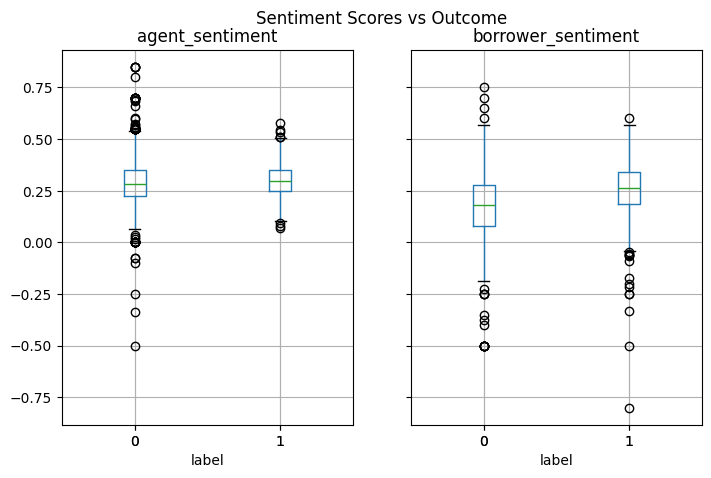

Accuracy: 0.6225
ROC AUC: 0.665311
F1: 0.6267918932278794
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1000
           1       0.62      0.63      0.63      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

# Assuming you already have scores_df with ['agent_sentiment','borrower_sentiment','type']
df = scores_df.copy()

# 1. Map categorical labels
df['label'] = df['type'].str.lower().map({'positive':1, 'positve':1, 'negative':0})

# 2. Exploratory comparison
print("Mean sentiment by outcome:")
print(df.groupby('label')[['agent_sentiment','borrower_sentiment']].mean())

# Visual
df.boxplot(column=['agent_sentiment','borrower_sentiment'], by='label', figsize=(8,5))
plt.suptitle("Sentiment Scores vs Outcome")
plt.show()

# 3. Predictive check
X = df[['agent_sentiment','borrower_sentiment']].values
y = df['label'].values

clf = LogisticRegression()
clf.fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)[:,1]

print("Accuracy:", accuracy_score(y,y_pred))
print("ROC AUC:", roc_auc_score(y,y_proba))
print("F1:", f1_score(y,y_pred))
print(classification_report(y,y_pred))


In [10]:
from scipy.stats import pointbiserialr

r_agent, p_agent = pointbiserialr(df['label'], df['agent_sentiment'])
r_borrower, p_borrower = pointbiserialr(df['label'], df['borrower_sentiment'])

print(f"Agent sentiment correlation with outcome: r={r_agent:.3f}, p={p_agent:.3g}")
print(f"Borrower sentiment correlation with outcome: r={r_borrower:.3f}, p={p_borrower:.3g}")


Agent sentiment correlation with outcome: r=0.042, p=0.0576
Borrower sentiment correlation with outcome: r=0.254, p=9.66e-31


<Axes: xlabel='agent_sentiment', ylabel='Density'>

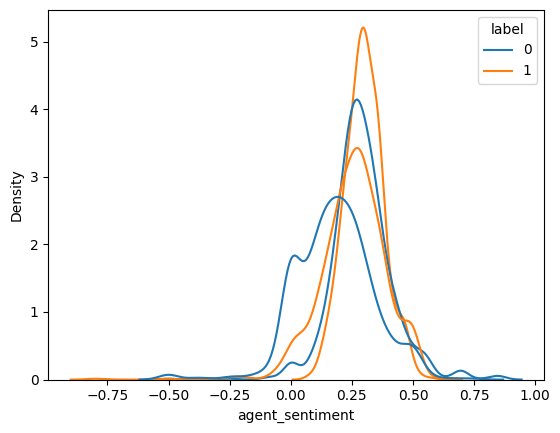

In [11]:
import seaborn as sns
sns.kdeplot(data=df, x="agent_sentiment", hue="label", common_norm=False)
sns.kdeplot(data=df, x="borrower_sentiment", hue="label", common_norm=False)


In [12]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(df[['agent_sentiment','borrower_sentiment']], df['label'])
print("Feature importances:", tree.feature_importances_)


Feature importances: [0.14979978 0.85020022]


In [ ]:
df

,call_id,agent_sentiment,borrower_sentiment,disposition,type,label
0,1558137f-4ab5-409e-8159-109c2e9358d5,0.269931,0.253716,No Pay - Bankruptcy,negative,0
1,05c54daf-9bca-4bd7-b833-b3ba8c1e06e0,0.385000,0.166667,No Pay - Cant pay now,negative,0
2,84fb4fec-b36f-43bc-a4ef-a27ba322c146,0.437097,0.409091,No Pay - Dispute,negative,0
3,2133927a-0d11-4d54-98d6-cd21c71417f0,0.197318,0.278526,No Pay - Dispute,negative,0
4,048518c6-c17c-4524-8ff3-6a0b2735863c,0.385000,0.200000,No Pay - Dispute,negative,0
...,...,...,...,...,...,...
1995,25050624-2831-4df2-b4c4-85f904e91bfe,0.390865,0.143132,Promise - Payment plan,positive,1
1996,79b7e0ab-0008-4832-a786-151ccb21bbf2,0.260606,0.361607,Payment Plan Modification,positive,1
1997,793afadb-488b-45cd-bc0c-12d7a1e732b8,0.207159,0.255993,Promise - Settlement in payments,positive,1
1998,c8078156-cc0e-4510-95a1-60550bc671b3,0.259342,0.207308,Promise - Settlement in payments,positive,1


In [13]:
!pip freeze > requirements.txt